In [1]:
import sys
sys.path.append('structural_bloc_diag_utils')

In [2]:
import ast
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytz
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
from StructuralBlocDiagModel import StructuralBlocDiagModel
from bloc_diag_utils import translate_nonzero_blocks

from BlocDiagModel import BlocDiagModel
from bloc_diag_plot_utils import load_df
from structural_bloc_diag_utils import test_sbd_model

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
# For a different MNIST-like dataset, replace 'fashion-MNIST' with 'MNIST' or 'Kuzushiji-MNIST'
df_fashion_MNIST_test_path = f"./bloc_diag_results/bloc_diag_dataset=fashion-MNIST/test_results__dataset=fashion-MNIST_bias=False_nonlinearity=SiLU__every_layer_except_last.csv"

df_fashion_MNIST_test = load_df(df_fashion_MNIST_test_path)

In [ ]:
df_fashion_MNIST_test

In [7]:
fine_tune_config = {
    'starting_learning_rate': 0.01,
    'weight_decay': 0.01,
    'scheduler': 'cosine annealing',
    'T_max': 300,
    'eta_min': 1e-6,
    'stopping_epoch': 300,
    'train_loader_batch_size': 512
}

In [8]:
config_name_to_fine_tune = ['config5', 'config4', 'config3', 'config2', 'config0', 'config7', 'config6', 'config1']
config = config_name_to_fine_tune[0]

In [9]:
df_to_fine_tune = df_fashion_MNIST_test[df_fashion_MNIST_test['config_name'] == config]

In [ ]:
df_to_fine_tune

In [11]:
for index, row in df_to_fine_tune.iterrows():
    # Convert the row to a dictionary
    dict_fine_tune_config = row.to_dict()

In [12]:
dict_fine_tune_config

{'model_name': 'bloc_diag_model',
 'dataset': 'fashion-MNIST',
 'layer_sizes': '[784, 100, 100, 10, 10]',
 'config_name': 'config5',
 'nonzero_blocks': '[1]*100 | [7]*16+[8]*84, [10]*10 | [10]*10, [1]*10 | [10]*10, [10]*1 | [10]*1',
 'if_bias': False,
 'nonlinear_activation': 'SiLU__every_layer_except_last',
 'learning_rate': 0.01,
 'scheduler_step_size': 20,
 'scheduler_gamma': 0.5,
 'train_loader_batch_size': 64,
 'stopping_epoch': 85,
 'multiplier_off_diag_loss': 4.0,
 'random_seed': 479001599,
 'time': '2024-05-11_14-19-11',
 'train_accuracy': 0.85435,
 'test_accuracy_before_dropping': 0.8389,
 'test_accuracy_off_diag_dropped': 0.8394,
 'time_consumption(s)': 1245.9203548431396}

In [83]:
dict_fine_tune_config = row.to_dict()
### rearrange the dict
dict_fine_tune_config['model_name'] = 'structural_bloc_diag_model'
dict_fine_tune_config['layer_sizes'] = ast.literal_eval(dict_fine_tune_config['layer_sizes'])
_ = dict_fine_tune_config.pop('learning_rate', 'No such key')
_ = dict_fine_tune_config.pop('scheduler_step_size', 'No such key')
_ = dict_fine_tune_config.pop('scheduler_gamma', 'No such key')
_ = dict_fine_tune_config.pop('train_loader_batch_size', 'No such key')
_ = dict_fine_tune_config.pop('stopping_epoch', 'No such key')
_ = dict_fine_tune_config.pop('multiplier_off_diag_loss', 'No such key')
_ = dict_fine_tune_config.pop('test_accuracy_before_dropping', 'No such key')
_ = dict_fine_tune_config.pop('time_consumption(s)', 'No such key')

dict_fine_tune_config['random_seed__bloc_diag_model'] = dict_fine_tune_config.pop('random_seed')
dict_fine_tune_config['time__bloc_diag_model'] = dict_fine_tune_config.pop('time')
dict_fine_tune_config['train_accuracy__bloc_diag_model'] = dict_fine_tune_config.pop('train_accuracy')
dict_fine_tune_config['test_accuracy_off_diag_dropped__bloc_diag_model'] = dict_fine_tune_config.pop('test_accuracy_off_diag_dropped')

### update configs for fine tuning
dict_fine_tune_config['starting_learning_rate'] = fine_tune_config['starting_learning_rate']
dict_fine_tune_config['weight_decay'] = fine_tune_config['weight_decay']
dict_fine_tune_config['scheduler'] = fine_tune_config['scheduler']
dict_fine_tune_config['T_max'] = fine_tune_config['T_max']
dict_fine_tune_config['eta_min'] = fine_tune_config['eta_min']
dict_fine_tune_config['stopping_epoch'] = fine_tune_config['stopping_epoch']
dict_fine_tune_config['train_loader_batch_size'] = fine_tune_config['train_loader_batch_size']


dict_fine_tune_config['random_seed'] = dict_fine_tune_config['random_seed__bloc_diag_model']

In [78]:
dict_fine_tune_config

{'model_name': 'structural_bloc_diag_model',
 'dataset': 'MNIST',
 'layer_sizes': [784, 100, 100, 10, 10],
 'config_name': 'config5',
 'nonzero_blocks': '[1]*100 | [7]*16+[8]*84, [10]*10 | [10]*10, [1]*10 | [10]*10, [10]*1 | [10]*1',
 'if_bias': False,
 'nonlinear_activation': 'SiLU__every_layer_except_last',
 'random_seed__bloc_diag_model': 479001599,
 'time__bloc_diag_model': '2024-05-11_12-04-29',
 'train_accuracy__bloc_diag_model': 0.9176166666666666,
 'test_accuracy_off_diag_dropped__bloc_diag_model': 0.915,
 'starting_learning_rate': 0.01,
 'weight_decay': 0.01,
 'scheduler': 'cosine annealing',
 'T_max': 300,
 'eta_min': 1e-06,
 'stopping_epoch': 300,
 'train_loader_batch_size': 512,
 'random_seed': 479001599}

In [11]:
train_MNIST = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_MNIST = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_fashion_MNIST = torchvision.datasets.FashionMNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_fashion_MNIST = torchvision.datasets.FashionMNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_Kuzushiji_MNIST = torchvision.datasets.KMNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_Kuzushiji_MNIST = torchvision.datasets.KMNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

config11
StructuralBlocDiagModel weights successfully set. Initial test loss = 1.0222. Initial test accu: 0.6299
Epoch 30: Train Loss: 0.9769, Train Accu: 0.6465, test loss: 0.9971, test accu: 0.6418
Epoch 30 time: 10.58s
Epoch 60: Train Loss: 0.9705, Train Accu: 0.6471, test loss: 0.9979, test accu: 0.6441
Epoch 60 time: 10.58s
Epoch 90: Train Loss: 0.9673, Train Accu: 0.6492, test loss: 0.9958, test accu: 0.6381
Epoch 90 time: 10.61s
Epoch 120: Train Loss: 0.9635, Train Accu: 0.6499, test loss: 0.9892, test accu: 0.6441
Epoch 120 time: 10.55s
Epoch 150: Train Loss: 0.9625, Train Accu: 0.6521, test loss: 0.9870, test accu: 0.6445
Epoch 150 time: 10.54s
Epoch 180: Train Loss: 0.9579, Train Accu: 0.6528, test loss: 0.9851, test accu: 0.6450
Epoch 180 time: 10.63s
Epoch 210: Train Loss: 0.9576, Train Accu: 0.6548, test loss: 0.9835, test accu: 0.6473
Epoch 210 time: 10.54s
Epoch 240: Train Loss: 0.9536, Train Accu: 0.6549, test loss: 0.9838, test accu: 0.6488
Epoch 240 time: 10.65s
Epoch

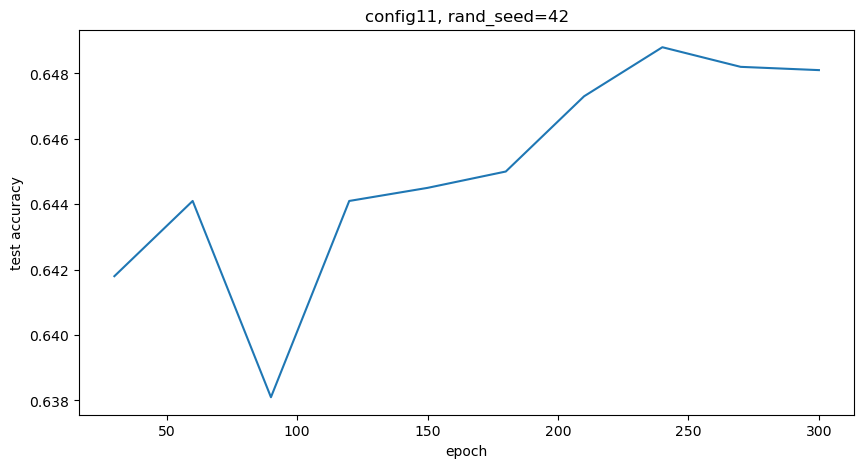

StructuralBlocDiagModel weights successfully set. Initial test loss = 1.0185. Initial test accu: 0.6340
Epoch 30: Train Loss: 0.9900, Train Accu: 0.6417, test loss: 1.0158, test accu: 0.6359
Epoch 30 time: 10.59s
Epoch 60: Train Loss: 0.9809, Train Accu: 0.6445, test loss: 1.0087, test accu: 0.6403
Epoch 60 time: 10.68s
Epoch 90: Train Loss: 0.9775, Train Accu: 0.6445, test loss: 1.0079, test accu: 0.6384
Epoch 90 time: 10.65s
Epoch 120: Train Loss: 0.9728, Train Accu: 0.6463, test loss: 1.0045, test accu: 0.6378
Epoch 120 time: 10.49s
Epoch 150: Train Loss: 0.9696, Train Accu: 0.6484, test loss: 1.0030, test accu: 0.6414
Epoch 150 time: 10.59s
Epoch 180: Train Loss: 0.9661, Train Accu: 0.6483, test loss: 1.0016, test accu: 0.6439
Epoch 180 time: 10.60s
Epoch 210: Train Loss: 0.9645, Train Accu: 0.6493, test loss: 0.9971, test accu: 0.6422
Epoch 210 time: 10.67s
Epoch 240: Train Loss: 0.9613, Train Accu: 0.6500, test loss: 0.9982, test accu: 0.6436
Epoch 240 time: 10.52s
Epoch 270: Tra

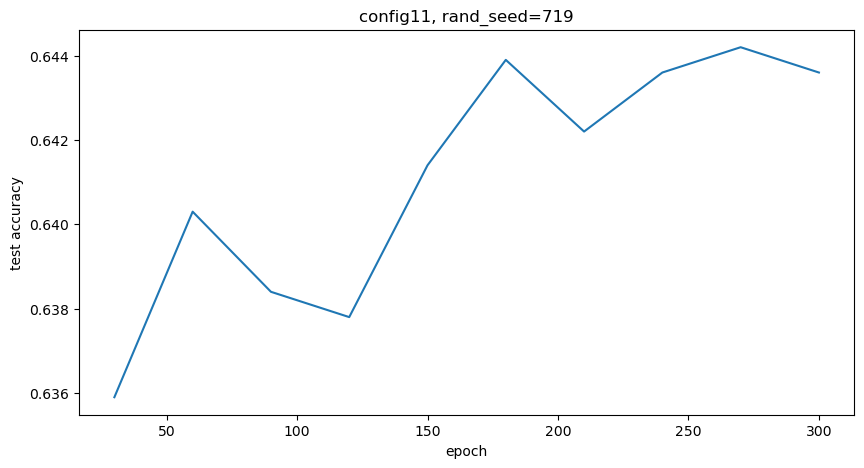

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9970. Initial test accu: 0.6369
Epoch 30: Train Loss: 0.9652, Train Accu: 0.6490, test loss: 0.9975, test accu: 0.6425
Epoch 30 time: 10.57s
Epoch 60: Train Loss: 0.9622, Train Accu: 0.6492, test loss: 0.9888, test accu: 0.6422
Epoch 60 time: 10.66s
Epoch 90: Train Loss: 0.9596, Train Accu: 0.6511, test loss: 0.9835, test accu: 0.6428
Epoch 90 time: 10.60s
Epoch 120: Train Loss: 0.9571, Train Accu: 0.6525, test loss: 0.9860, test accu: 0.6450
Epoch 120 time: 10.62s
Epoch 150: Train Loss: 0.9539, Train Accu: 0.6527, test loss: 0.9829, test accu: 0.6468
Epoch 150 time: 10.54s
Epoch 180: Train Loss: 0.9519, Train Accu: 0.6534, test loss: 0.9814, test accu: 0.6474
Epoch 180 time: 10.49s
Epoch 210: Train Loss: 0.9487, Train Accu: 0.6559, test loss: 0.9802, test accu: 0.6492
Epoch 210 time: 10.60s
Epoch 240: Train Loss: 0.9460, Train Accu: 0.6558, test loss: 0.9791, test accu: 0.6481
Epoch 240 time: 10.59s
Epoch 270: Tra

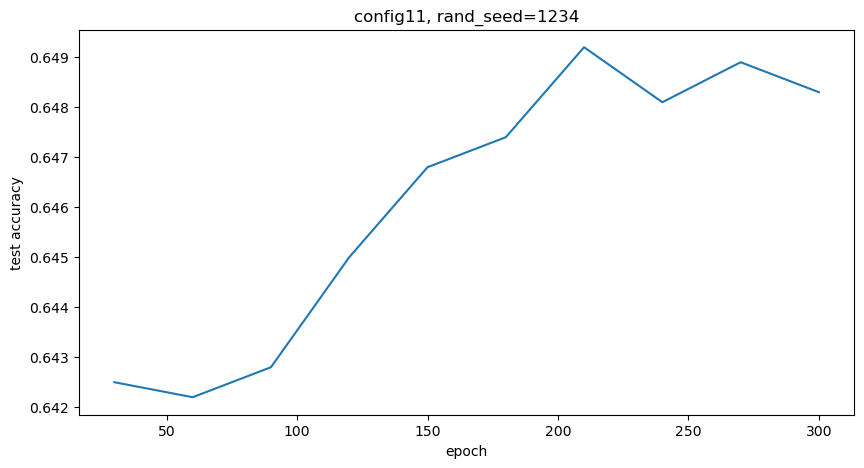

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9925. Initial test accu: 0.6361
Epoch 30: Train Loss: 0.9575, Train Accu: 0.6501, test loss: 0.9869, test accu: 0.6442
Epoch 30 time: 10.41s
Epoch 60: Train Loss: 0.9523, Train Accu: 0.6543, test loss: 0.9835, test accu: 0.6396
Epoch 60 time: 10.56s
Epoch 90: Train Loss: 0.9519, Train Accu: 0.6528, test loss: 0.9773, test accu: 0.6454
Epoch 90 time: 10.50s
Epoch 120: Train Loss: 0.9475, Train Accu: 0.6563, test loss: 0.9738, test accu: 0.6462
Epoch 120 time: 10.48s
Epoch 150: Train Loss: 0.9456, Train Accu: 0.6570, test loss: 0.9750, test accu: 0.6461
Epoch 150 time: 10.42s
Epoch 180: Train Loss: 0.9431, Train Accu: 0.6584, test loss: 0.9715, test accu: 0.6476
Epoch 180 time: 10.61s
Epoch 210: Train Loss: 0.9394, Train Accu: 0.6590, test loss: 0.9724, test accu: 0.6486
Epoch 210 time: 10.53s
Epoch 240: Train Loss: 0.9400, Train Accu: 0.6600, test loss: 0.9701, test accu: 0.6475
Epoch 240 time: 10.50s
Epoch 270: Tra

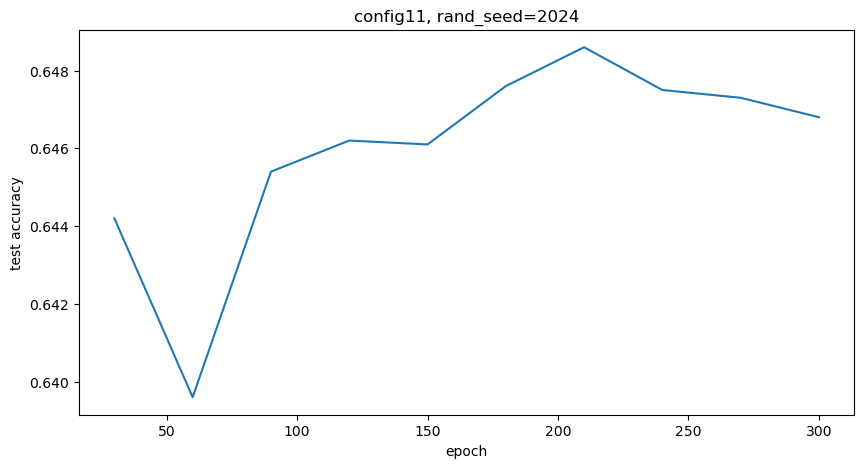

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9931. Initial test accu: 0.6519
Epoch 30: Train Loss: 0.9431, Train Accu: 0.6557, test loss: 0.9770, test accu: 0.6460
Epoch 30 time: 10.51s
Epoch 60: Train Loss: 0.9400, Train Accu: 0.6567, test loss: 0.9637, test accu: 0.6548
Epoch 60 time: 10.53s
Epoch 90: Train Loss: 0.9384, Train Accu: 0.6573, test loss: 0.9701, test accu: 0.6565
Epoch 90 time: 10.53s
Epoch 120: Train Loss: 0.9332, Train Accu: 0.6584, test loss: 0.9627, test accu: 0.6539
Epoch 120 time: 10.64s
Epoch 150: Train Loss: 0.9320, Train Accu: 0.6576, test loss: 0.9608, test accu: 0.6538
Epoch 150 time: 10.44s
Epoch 180: Train Loss: 0.9295, Train Accu: 0.6594, test loss: 0.9597, test accu: 0.6548
Epoch 180 time: 10.48s
Epoch 210: Train Loss: 0.9268, Train Accu: 0.6605, test loss: 0.9577, test accu: 0.6610
Epoch 210 time: 10.50s
Epoch 240: Train Loss: 0.9259, Train Accu: 0.6609, test loss: 0.9568, test accu: 0.6609
Epoch 240 time: 10.48s
Epoch 270: Tra

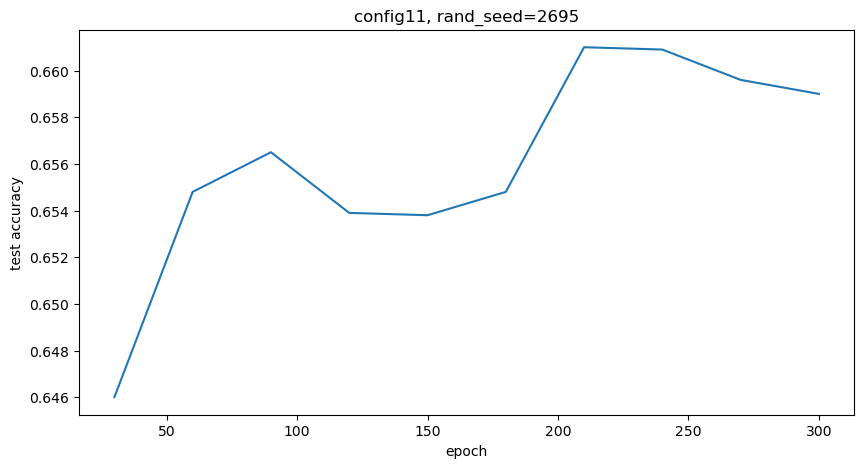

StructuralBlocDiagModel weights successfully set. Initial test loss = 1.0094. Initial test accu: 0.6364
Epoch 30: Train Loss: 0.9814, Train Accu: 0.6419, test loss: 0.9999, test accu: 0.6412
Epoch 30 time: 10.47s
Epoch 60: Train Loss: 0.9699, Train Accu: 0.6455, test loss: 0.9972, test accu: 0.6431
Epoch 60 time: 10.49s
Epoch 90: Train Loss: 0.9690, Train Accu: 0.6463, test loss: 0.9958, test accu: 0.6360
Epoch 90 time: 10.55s
Epoch 120: Train Loss: 0.9656, Train Accu: 0.6480, test loss: 0.9945, test accu: 0.6392
Epoch 120 time: 10.39s
Epoch 150: Train Loss: 0.9599, Train Accu: 0.6496, test loss: 0.9867, test accu: 0.6482
Epoch 150 time: 10.52s
Epoch 180: Train Loss: 0.9574, Train Accu: 0.6506, test loss: 0.9850, test accu: 0.6484
Epoch 180 time: 10.44s
Epoch 210: Train Loss: 0.9550, Train Accu: 0.6517, test loss: 0.9860, test accu: 0.6478
Epoch 210 time: 10.38s
Epoch 240: Train Loss: 0.9519, Train Accu: 0.6531, test loss: 0.9828, test accu: 0.6486
Epoch 240 time: 10.42s
Epoch 270: Tra

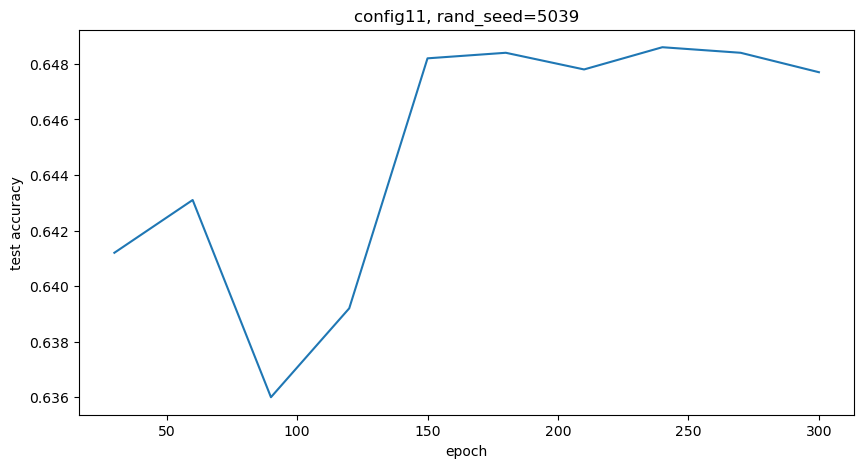

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9939. Initial test accu: 0.6409
Epoch 30: Train Loss: 0.9597, Train Accu: 0.6538, test loss: 0.9798, test accu: 0.6484
Epoch 30 time: 10.59s
Epoch 60: Train Loss: 0.9571, Train Accu: 0.6531, test loss: 0.9824, test accu: 0.6456
Epoch 60 time: 10.51s
Epoch 90: Train Loss: 0.9550, Train Accu: 0.6535, test loss: 0.9774, test accu: 0.6508
Epoch 90 time: 10.45s
Epoch 120: Train Loss: 0.9504, Train Accu: 0.6557, test loss: 0.9797, test accu: 0.6475
Epoch 120 time: 10.59s
Epoch 150: Train Loss: 0.9462, Train Accu: 0.6576, test loss: 0.9741, test accu: 0.6485
Epoch 150 time: 10.50s
Epoch 180: Train Loss: 0.9442, Train Accu: 0.6595, test loss: 0.9718, test accu: 0.6509
Epoch 180 time: 10.47s
Epoch 210: Train Loss: 0.9425, Train Accu: 0.6593, test loss: 0.9708, test accu: 0.6525
Epoch 210 time: 10.59s
Epoch 240: Train Loss: 0.9407, Train Accu: 0.6601, test loss: 0.9699, test accu: 0.6530
Epoch 240 time: 10.48s
Epoch 270: Tra

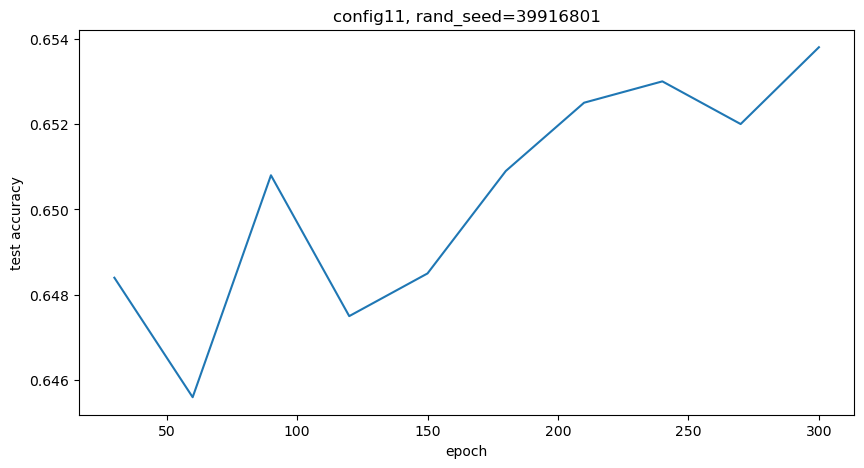

StructuralBlocDiagModel weights successfully set. Initial test loss = 1.0003. Initial test accu: 0.6409
Epoch 30: Train Loss: 0.9534, Train Accu: 0.6534, test loss: 0.9941, test accu: 0.6424
Epoch 30 time: 10.44s
Epoch 60: Train Loss: 0.9494, Train Accu: 0.6546, test loss: 0.9887, test accu: 0.6449
Epoch 60 time: 10.51s
Epoch 90: Train Loss: 0.9472, Train Accu: 0.6570, test loss: 0.9890, test accu: 0.6438
Epoch 90 time: 10.50s
Epoch 120: Train Loss: 0.9428, Train Accu: 0.6563, test loss: 0.9860, test accu: 0.6474
Epoch 120 time: 10.41s
Epoch 150: Train Loss: 0.9398, Train Accu: 0.6584, test loss: 0.9881, test accu: 0.6434
Epoch 150 time: 10.55s
Epoch 180: Train Loss: 0.9389, Train Accu: 0.6584, test loss: 0.9814, test accu: 0.6480
Epoch 180 time: 10.49s
Epoch 210: Train Loss: 0.9360, Train Accu: 0.6602, test loss: 0.9818, test accu: 0.6463
Epoch 210 time: 10.46s
Epoch 240: Train Loss: 0.9327, Train Accu: 0.6604, test loss: 0.9815, test accu: 0.6478
Epoch 240 time: 10.65s
Epoch 270: Tra

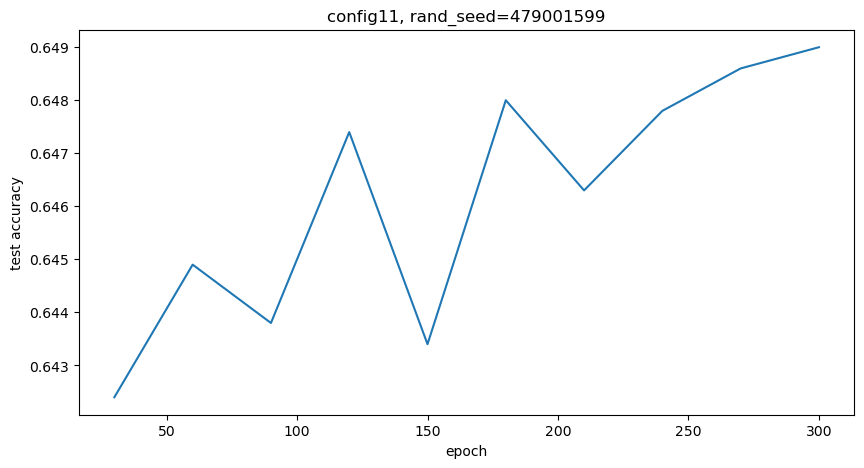

config12
StructuralBlocDiagModel weights successfully set. Initial test loss = 0.7509. Initial test accu: 0.7533
Epoch 30: Train Loss: 0.7038, Train Accu: 0.7661, test loss: 0.7427, test accu: 0.7548
Epoch 30 time: 10.48s
Epoch 60: Train Loss: 0.7002, Train Accu: 0.7682, test loss: 0.7401, test accu: 0.7562
Epoch 60 time: 10.49s
Epoch 90: Train Loss: 0.6968, Train Accu: 0.7685, test loss: 0.7367, test accu: 0.7596
Epoch 90 time: 10.50s
Epoch 120: Train Loss: 0.6955, Train Accu: 0.7699, test loss: 0.7338, test accu: 0.7598
Epoch 120 time: 10.45s
Epoch 150: Train Loss: 0.6923, Train Accu: 0.7704, test loss: 0.7332, test accu: 0.7581
Epoch 150 time: 10.38s
Epoch 180: Train Loss: 0.6909, Train Accu: 0.7706, test loss: 0.7332, test accu: 0.7586
Epoch 180 time: 10.73s
Epoch 210: Train Loss: 0.6885, Train Accu: 0.7716, test loss: 0.7297, test accu: 0.7597
Epoch 210 time: 10.62s
Epoch 240: Train Loss: 0.6867, Train Accu: 0.7721, test loss: 0.7291, test accu: 0.7609
Epoch 240 time: 10.56s
Epoch

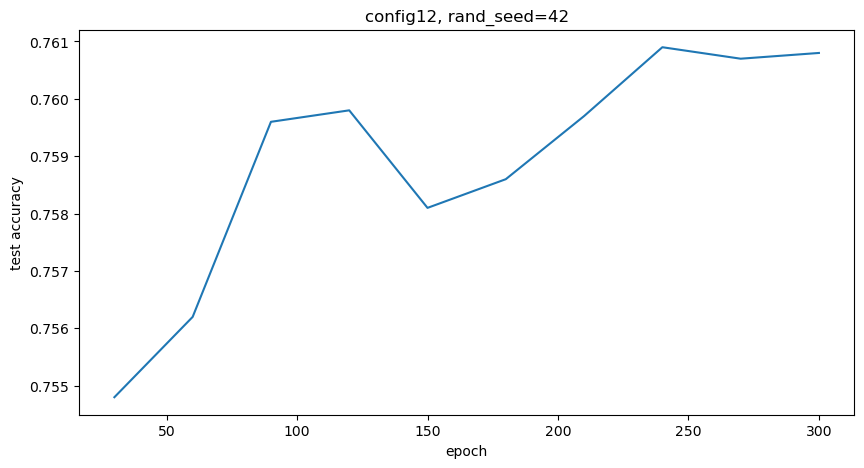

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6871. Initial test accu: 0.7655
Epoch 30: Train Loss: 0.6477, Train Accu: 0.7752, test loss: 0.6878, test accu: 0.7642
Epoch 30 time: 10.49s
Epoch 60: Train Loss: 0.6470, Train Accu: 0.7763, test loss: 0.6878, test accu: 0.7593
Epoch 60 time: 10.49s
Epoch 90: Train Loss: 0.6437, Train Accu: 0.7764, test loss: 0.6852, test accu: 0.7646
Epoch 90 time: 10.47s
Epoch 120: Train Loss: 0.6433, Train Accu: 0.7767, test loss: 0.6816, test accu: 0.7676
Epoch 120 time: 10.44s
Epoch 150: Train Loss: 0.6402, Train Accu: 0.7771, test loss: 0.6814, test accu: 0.7635
Epoch 150 time: 10.54s
Epoch 180: Train Loss: 0.6389, Train Accu: 0.7783, test loss: 0.6788, test accu: 0.7672
Epoch 180 time: 10.41s
Epoch 210: Train Loss: 0.6371, Train Accu: 0.7791, test loss: 0.6801, test accu: 0.7657
Epoch 210 time: 10.52s
Epoch 240: Train Loss: 0.6355, Train Accu: 0.7796, test loss: 0.6785, test accu: 0.7672
Epoch 240 time: 10.48s
Epoch 270: Tra

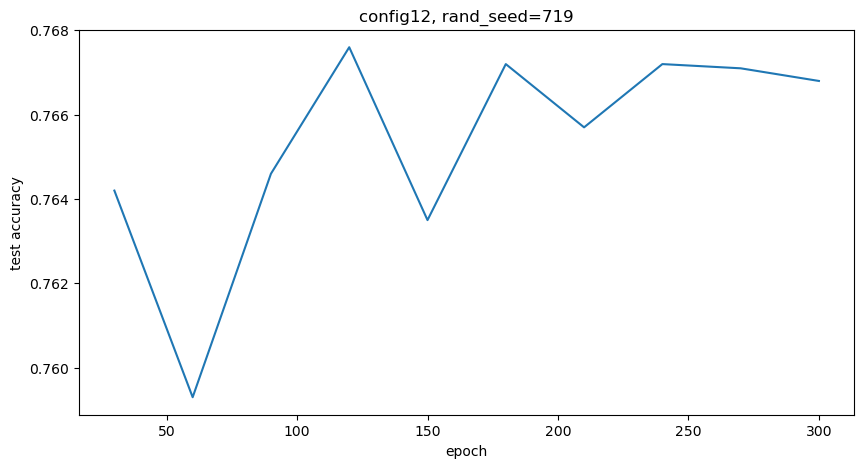

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.7187. Initial test accu: 0.7564
Epoch 30: Train Loss: 0.6734, Train Accu: 0.7690, test loss: 0.7073, test accu: 0.7604
Epoch 30 time: 10.49s
Epoch 60: Train Loss: 0.6691, Train Accu: 0.7698, test loss: 0.7068, test accu: 0.7584
Epoch 60 time: 10.50s
Epoch 90: Train Loss: 0.6654, Train Accu: 0.7713, test loss: 0.7025, test accu: 0.7604
Epoch 90 time: 10.55s
Epoch 120: Train Loss: 0.6616, Train Accu: 0.7719, test loss: 0.7009, test accu: 0.7613
Epoch 120 time: 10.55s
Epoch 150: Train Loss: 0.6612, Train Accu: 0.7727, test loss: 0.7001, test accu: 0.7604
Epoch 150 time: 10.53s
Epoch 180: Train Loss: 0.6580, Train Accu: 0.7736, test loss: 0.6970, test accu: 0.7627
Epoch 180 time: 10.57s
Epoch 210: Train Loss: 0.6555, Train Accu: 0.7739, test loss: 0.6973, test accu: 0.7627
Epoch 210 time: 10.42s
Epoch 240: Train Loss: 0.6530, Train Accu: 0.7748, test loss: 0.6969, test accu: 0.7626
Epoch 240 time: 10.56s
Epoch 270: Tra

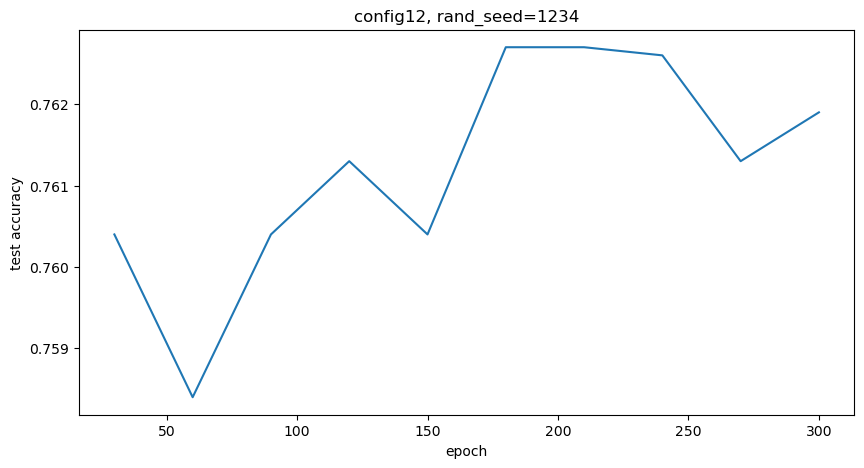

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.7212. Initial test accu: 0.7554
Epoch 30: Train Loss: 0.6817, Train Accu: 0.7670, test loss: 0.7170, test accu: 0.7572
Epoch 30 time: 10.63s
Epoch 60: Train Loss: 0.6780, Train Accu: 0.7674, test loss: 0.7180, test accu: 0.7584
Epoch 60 time: 10.51s
Epoch 90: Train Loss: 0.6762, Train Accu: 0.7689, test loss: 0.7145, test accu: 0.7578
Epoch 90 time: 10.50s
Epoch 120: Train Loss: 0.6738, Train Accu: 0.7687, test loss: 0.7147, test accu: 0.7586
Epoch 120 time: 10.60s
Epoch 150: Train Loss: 0.6729, Train Accu: 0.7698, test loss: 0.7134, test accu: 0.7578
Epoch 150 time: 10.47s
Epoch 180: Train Loss: 0.6702, Train Accu: 0.7706, test loss: 0.7105, test accu: 0.7570
Epoch 180 time: 10.56s
Epoch 210: Train Loss: 0.6666, Train Accu: 0.7712, test loss: 0.7092, test accu: 0.7611
Epoch 210 time: 10.63s
Epoch 240: Train Loss: 0.6665, Train Accu: 0.7721, test loss: 0.7085, test accu: 0.7585
Epoch 240 time: 10.54s
Epoch 270: Tra

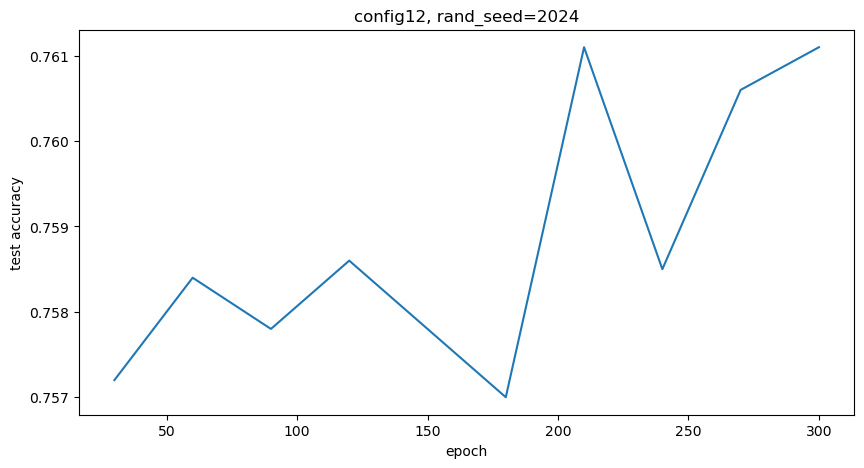

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.7440. Initial test accu: 0.7469
Epoch 30: Train Loss: 0.6954, Train Accu: 0.7650, test loss: 0.7384, test accu: 0.7531
Epoch 30 time: 10.54s
Epoch 60: Train Loss: 0.6913, Train Accu: 0.7647, test loss: 0.7341, test accu: 0.7520
Epoch 60 time: 10.59s
Epoch 90: Train Loss: 0.6889, Train Accu: 0.7657, test loss: 0.7344, test accu: 0.7531
Epoch 90 time: 10.52s
Epoch 120: Train Loss: 0.6869, Train Accu: 0.7664, test loss: 0.7331, test accu: 0.7529
Epoch 120 time: 10.48s
Epoch 150: Train Loss: 0.6849, Train Accu: 0.7674, test loss: 0.7322, test accu: 0.7528
Epoch 150 time: 10.65s
Epoch 180: Train Loss: 0.6828, Train Accu: 0.7690, test loss: 0.7304, test accu: 0.7529
Epoch 180 time: 10.52s
Epoch 210: Train Loss: 0.6804, Train Accu: 0.7700, test loss: 0.7275, test accu: 0.7563
Epoch 210 time: 10.57s
Epoch 240: Train Loss: 0.6790, Train Accu: 0.7697, test loss: 0.7278, test accu: 0.7547
Epoch 240 time: 10.72s
Epoch 270: Tra

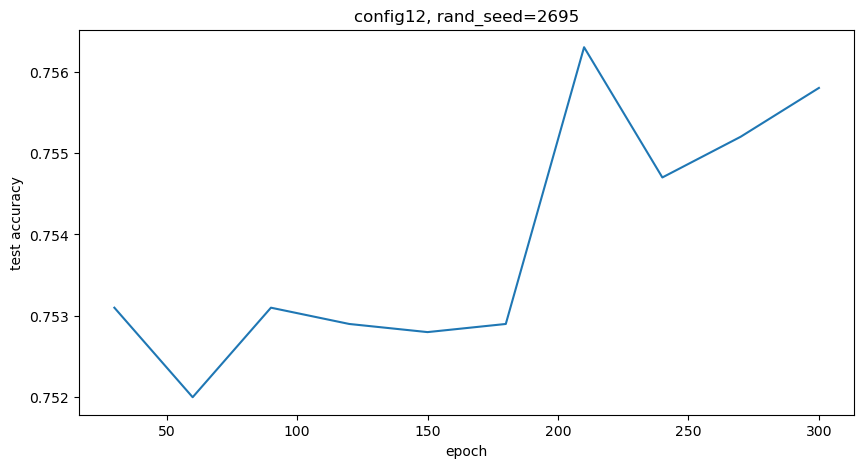

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.7316. Initial test accu: 0.7467
Epoch 30: Train Loss: 0.6892, Train Accu: 0.7614, test loss: 0.7247, test accu: 0.7520
Epoch 30 time: 11.12s
Epoch 60: Train Loss: 0.6838, Train Accu: 0.7626, test loss: 0.7256, test accu: 0.7495
Epoch 60 time: 11.29s
Epoch 90: Train Loss: 0.6808, Train Accu: 0.7655, test loss: 0.7210, test accu: 0.7514
Epoch 90 time: 11.06s
Epoch 120: Train Loss: 0.6776, Train Accu: 0.7654, test loss: 0.7151, test accu: 0.7541
Epoch 120 time: 11.30s
Epoch 150: Train Loss: 0.6757, Train Accu: 0.7665, test loss: 0.7151, test accu: 0.7537
Epoch 150 time: 10.66s
Epoch 180: Train Loss: 0.6731, Train Accu: 0.7670, test loss: 0.7175, test accu: 0.7561
Epoch 180 time: 10.98s
Epoch 210: Train Loss: 0.6705, Train Accu: 0.7679, test loss: 0.7138, test accu: 0.7532
Epoch 210 time: 11.27s
Epoch 240: Train Loss: 0.6691, Train Accu: 0.7682, test loss: 0.7125, test accu: 0.7559
Epoch 240 time: 10.84s
Epoch 270: Tra

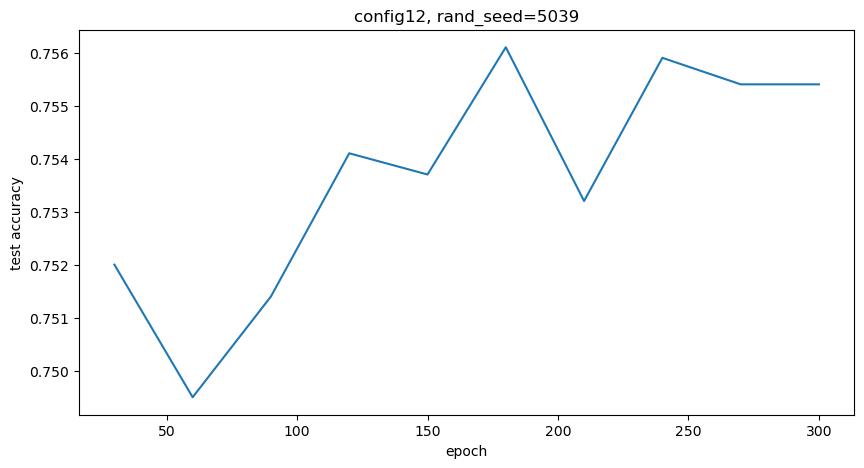

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6952. Initial test accu: 0.7617
Epoch 30: Train Loss: 0.6464, Train Accu: 0.7756, test loss: 0.6905, test accu: 0.7629
Epoch 30 time: 10.66s
Epoch 60: Train Loss: 0.6414, Train Accu: 0.7773, test loss: 0.6928, test accu: 0.7650
Epoch 60 time: 11.07s
Epoch 90: Train Loss: 0.6380, Train Accu: 0.7799, test loss: 0.6851, test accu: 0.7673
Epoch 90 time: 10.83s
Epoch 120: Train Loss: 0.6382, Train Accu: 0.7794, test loss: 0.6843, test accu: 0.7647
Epoch 120 time: 10.81s
Epoch 150: Train Loss: 0.6344, Train Accu: 0.7806, test loss: 0.6834, test accu: 0.7669
Epoch 150 time: 10.67s
Epoch 180: Train Loss: 0.6323, Train Accu: 0.7817, test loss: 0.6868, test accu: 0.7650
Epoch 180 time: 10.79s
Epoch 210: Train Loss: 0.6292, Train Accu: 0.7822, test loss: 0.6801, test accu: 0.7677
Epoch 210 time: 10.64s
Epoch 240: Train Loss: 0.6275, Train Accu: 0.7827, test loss: 0.6796, test accu: 0.7687
Epoch 240 time: 11.11s
Epoch 270: Tra

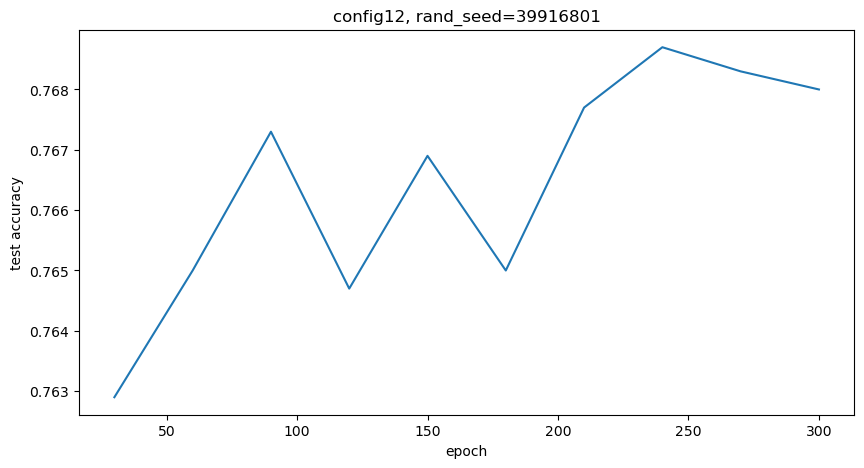

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.7398. Initial test accu: 0.7462
Epoch 30: Train Loss: 0.6982, Train Accu: 0.7580, test loss: 0.7349, test accu: 0.7504
Epoch 30 time: 11.30s
Epoch 60: Train Loss: 0.6937, Train Accu: 0.7592, test loss: 0.7340, test accu: 0.7446
Epoch 60 time: 11.13s
Epoch 90: Train Loss: 0.6916, Train Accu: 0.7583, test loss: 0.7326, test accu: 0.7449
Epoch 90 time: 10.53s
Epoch 120: Train Loss: 0.6888, Train Accu: 0.7590, test loss: 0.7342, test accu: 0.7478
Epoch 120 time: 10.70s
Epoch 150: Train Loss: 0.6875, Train Accu: 0.7620, test loss: 0.7282, test accu: 0.7496
Epoch 150 time: 10.80s
Epoch 180: Train Loss: 0.6824, Train Accu: 0.7618, test loss: 0.7302, test accu: 0.7496
Epoch 180 time: 11.29s
Epoch 210: Train Loss: 0.6820, Train Accu: 0.7629, test loss: 0.7260, test accu: 0.7496
Epoch 210 time: 10.70s
Epoch 240: Train Loss: 0.6790, Train Accu: 0.7640, test loss: 0.7262, test accu: 0.7502
Epoch 240 time: 11.54s
Epoch 270: Tra

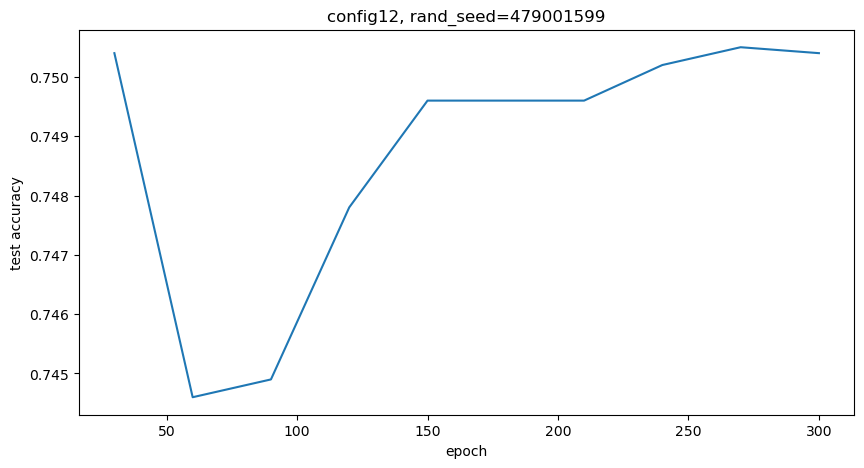

config13
StructuralBlocDiagModel weights successfully set. Initial test loss = 1.0055. Initial test accu: 0.6448
Epoch 30: Train Loss: 0.9227, Train Accu: 0.6675, test loss: 0.9562, test accu: 0.6608
Epoch 30 time: 11.30s
Epoch 60: Train Loss: 0.9191, Train Accu: 0.6685, test loss: 0.9503, test accu: 0.6635
Epoch 60 time: 10.48s
Epoch 90: Train Loss: 0.9155, Train Accu: 0.6679, test loss: 0.9490, test accu: 0.6632
Epoch 90 time: 11.20s
Epoch 120: Train Loss: 0.9096, Train Accu: 0.6694, test loss: 0.9438, test accu: 0.6624
Epoch 120 time: 10.60s
Epoch 150: Train Loss: 0.9073, Train Accu: 0.6703, test loss: 0.9457, test accu: 0.6638
Epoch 150 time: 10.27s
Epoch 180: Train Loss: 0.9042, Train Accu: 0.6718, test loss: 0.9460, test accu: 0.6639
Epoch 180 time: 10.04s
Epoch 210: Train Loss: 0.9009, Train Accu: 0.6721, test loss: 0.9421, test accu: 0.6648
Epoch 210 time: 10.93s
Epoch 240: Train Loss: 0.8999, Train Accu: 0.6727, test loss: 0.9415, test accu: 0.6647
Epoch 240 time: 10.13s
Epoch

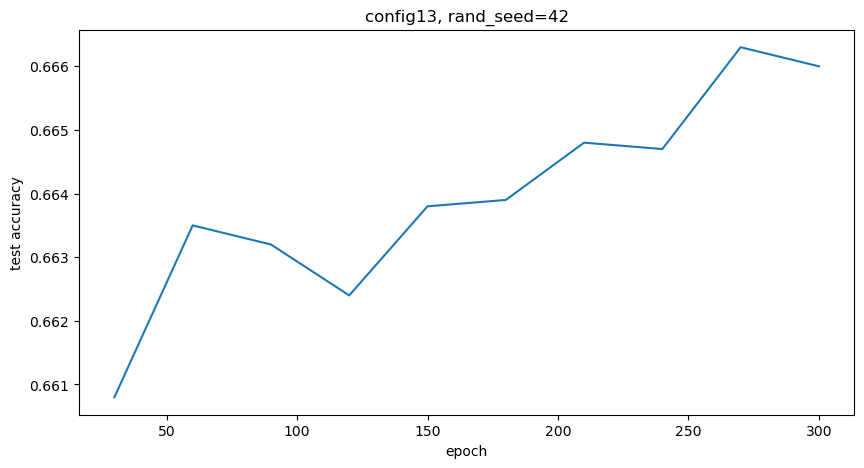

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9831. Initial test accu: 0.6373
Epoch 30: Train Loss: 0.9405, Train Accu: 0.6546, test loss: 0.9781, test accu: 0.6400
Epoch 30 time: 10.12s
Epoch 60: Train Loss: 0.9365, Train Accu: 0.6546, test loss: 0.9745, test accu: 0.6432
Epoch 60 time: 10.05s
Epoch 90: Train Loss: 0.9308, Train Accu: 0.6574, test loss: 0.9704, test accu: 0.6436
Epoch 90 time: 10.45s
Epoch 120: Train Loss: 0.9256, Train Accu: 0.6603, test loss: 0.9686, test accu: 0.6464
Epoch 120 time: 10.45s
Epoch 150: Train Loss: 0.9229, Train Accu: 0.6619, test loss: 0.9645, test accu: 0.6519
Epoch 150 time: 10.29s
Epoch 180: Train Loss: 0.9206, Train Accu: 0.6636, test loss: 0.9633, test accu: 0.6494
Epoch 180 time: 10.18s
Epoch 210: Train Loss: 0.9165, Train Accu: 0.6645, test loss: 0.9621, test accu: 0.6509
Epoch 210 time: 10.04s
Epoch 240: Train Loss: 0.9142, Train Accu: 0.6656, test loss: 0.9605, test accu: 0.6500
Epoch 240 time: 10.53s
Epoch 270: Tra

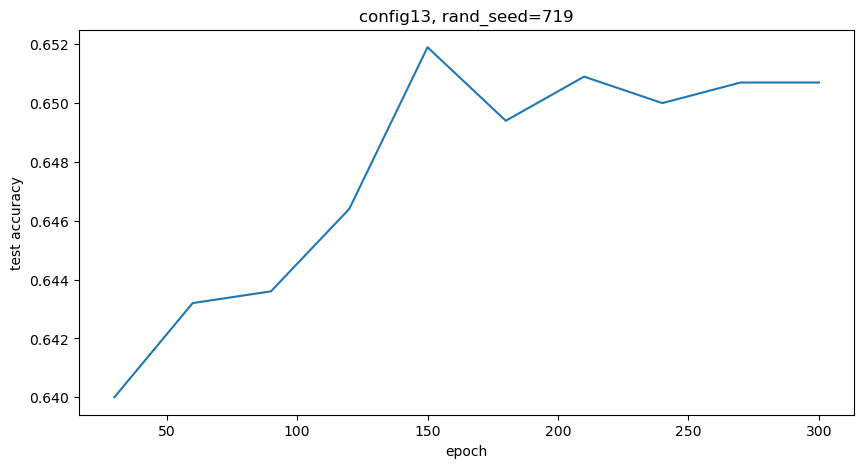

StructuralBlocDiagModel weights successfully set. Initial test loss = 1.0202. Initial test accu: 0.6483
Epoch 30: Train Loss: 0.9251, Train Accu: 0.6613, test loss: 0.9770, test accu: 0.6537
Epoch 30 time: 10.39s
Epoch 60: Train Loss: 0.9164, Train Accu: 0.6656, test loss: 0.9677, test accu: 0.6596
Epoch 60 time: 10.52s
Epoch 90: Train Loss: 0.9093, Train Accu: 0.6677, test loss: 0.9584, test accu: 0.6624
Epoch 90 time: 10.33s
Epoch 120: Train Loss: 0.9041, Train Accu: 0.6696, test loss: 0.9576, test accu: 0.6616
Epoch 120 time: 10.38s
Epoch 150: Train Loss: 0.9012, Train Accu: 0.6709, test loss: 0.9514, test accu: 0.6628
Epoch 150 time: 10.24s
Epoch 180: Train Loss: 0.8983, Train Accu: 0.6718, test loss: 0.9505, test accu: 0.6641
Epoch 180 time: 10.26s
Epoch 210: Train Loss: 0.8945, Train Accu: 0.6727, test loss: 0.9493, test accu: 0.6653
Epoch 210 time: 11.10s
Epoch 240: Train Loss: 0.8932, Train Accu: 0.6731, test loss: 0.9483, test accu: 0.6657
Epoch 240 time: 10.66s
Epoch 270: Tra

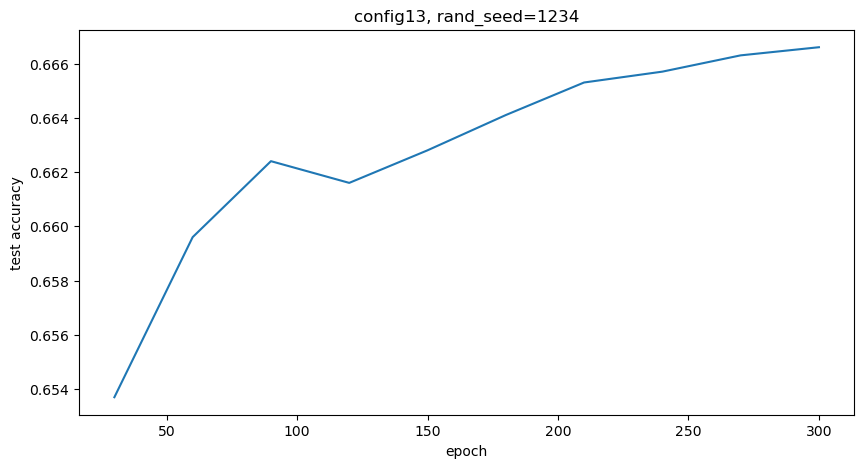

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9575. Initial test accu: 0.6574
Epoch 30: Train Loss: 0.9258, Train Accu: 0.6620, test loss: 0.9450, test accu: 0.6520
Epoch 30 time: 10.83s
Epoch 60: Train Loss: 0.9215, Train Accu: 0.6632, test loss: 0.9375, test accu: 0.6555
Epoch 60 time: 11.10s
Epoch 90: Train Loss: 0.9180, Train Accu: 0.6654, test loss: 0.9364, test accu: 0.6566
Epoch 90 time: 11.12s
Epoch 120: Train Loss: 0.9125, Train Accu: 0.6662, test loss: 0.9376, test accu: 0.6584
Epoch 120 time: 10.88s
Epoch 150: Train Loss: 0.9095, Train Accu: 0.6680, test loss: 0.9366, test accu: 0.6594
Epoch 150 time: 11.07s
Epoch 180: Train Loss: 0.9055, Train Accu: 0.6682, test loss: 0.9327, test accu: 0.6617
Epoch 180 time: 10.03s
Epoch 210: Train Loss: 0.9041, Train Accu: 0.6699, test loss: 0.9306, test accu: 0.6625
Epoch 210 time: 11.39s
Epoch 240: Train Loss: 0.8997, Train Accu: 0.6704, test loss: 0.9290, test accu: 0.6616
Epoch 240 time: 11.94s
Epoch 270: Tra

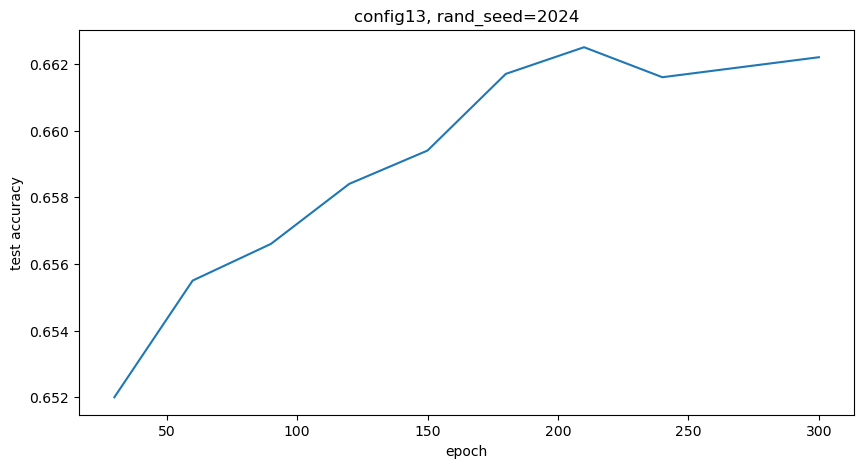

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9794. Initial test accu: 0.6495
Epoch 30: Train Loss: 0.9290, Train Accu: 0.6591, test loss: 0.9588, test accu: 0.6488
Epoch 30 time: 11.54s
Epoch 60: Train Loss: 0.9235, Train Accu: 0.6598, test loss: 0.9529, test accu: 0.6512
Epoch 60 time: 11.59s
Epoch 90: Train Loss: 0.9194, Train Accu: 0.6612, test loss: 0.9545, test accu: 0.6489
Epoch 90 time: 11.72s
Epoch 120: Train Loss: 0.9152, Train Accu: 0.6627, test loss: 0.9526, test accu: 0.6495
Epoch 120 time: 12.08s
Epoch 150: Train Loss: 0.9112, Train Accu: 0.6636, test loss: 0.9506, test accu: 0.6499
Epoch 150 time: 11.72s
Epoch 180: Train Loss: 0.9100, Train Accu: 0.6638, test loss: 0.9464, test accu: 0.6498
Epoch 180 time: 11.51s
Epoch 210: Train Loss: 0.9071, Train Accu: 0.6654, test loss: 0.9480, test accu: 0.6534
Epoch 210 time: 11.76s
Epoch 240: Train Loss: 0.9061, Train Accu: 0.6657, test loss: 0.9457, test accu: 0.6526
Epoch 240 time: 11.74s
Epoch 270: Tra

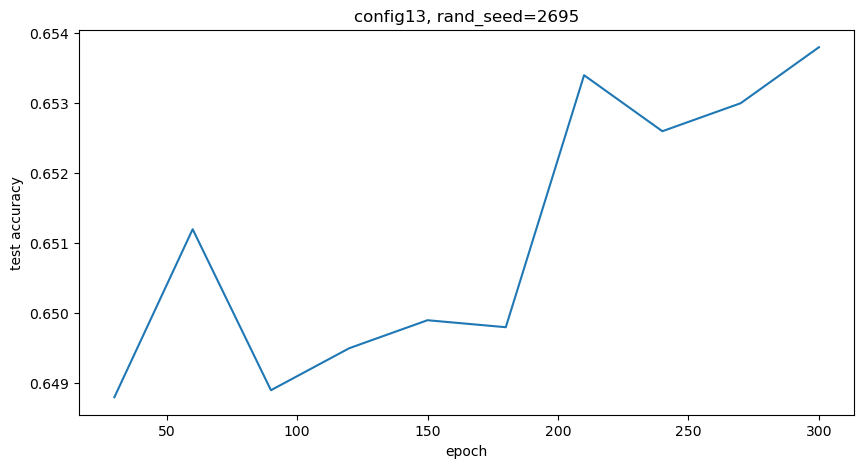

StructuralBlocDiagModel weights successfully set. Initial test loss = 1.0244. Initial test accu: 0.6293
Epoch 30: Train Loss: 0.9428, Train Accu: 0.6521, test loss: 0.9727, test accu: 0.6487
Epoch 30 time: 11.51s
Epoch 60: Train Loss: 0.9389, Train Accu: 0.6531, test loss: 0.9631, test accu: 0.6476
Epoch 60 time: 11.89s
Epoch 90: Train Loss: 0.9345, Train Accu: 0.6538, test loss: 0.9595, test accu: 0.6495
Epoch 90 time: 11.51s
Epoch 120: Train Loss: 0.9282, Train Accu: 0.6576, test loss: 0.9600, test accu: 0.6486
Epoch 120 time: 11.71s
Epoch 150: Train Loss: 0.9251, Train Accu: 0.6583, test loss: 0.9560, test accu: 0.6514
Epoch 150 time: 10.91s
Epoch 180: Train Loss: 0.9222, Train Accu: 0.6600, test loss: 0.9559, test accu: 0.6543
Epoch 180 time: 10.97s
Epoch 210: Train Loss: 0.9186, Train Accu: 0.6617, test loss: 0.9527, test accu: 0.6552
Epoch 210 time: 10.57s
Epoch 240: Train Loss: 0.9164, Train Accu: 0.6625, test loss: 0.9490, test accu: 0.6569
Epoch 240 time: 10.86s
Epoch 270: Tra

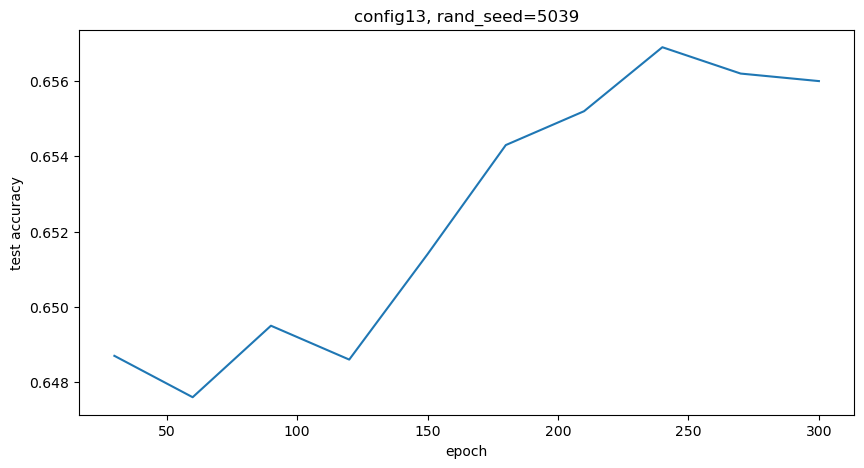

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9897. Initial test accu: 0.6432
Epoch 30: Train Loss: 0.9520, Train Accu: 0.6531, test loss: 0.9832, test accu: 0.6461
Epoch 30 time: 10.43s
Epoch 60: Train Loss: 0.9499, Train Accu: 0.6536, test loss: 0.9789, test accu: 0.6503
Epoch 60 time: 10.51s
Epoch 90: Train Loss: 0.9406, Train Accu: 0.6560, test loss: 0.9743, test accu: 0.6478
Epoch 90 time: 10.56s
Epoch 120: Train Loss: 0.9384, Train Accu: 0.6568, test loss: 0.9761, test accu: 0.6491
Epoch 120 time: 10.67s
Epoch 150: Train Loss: 0.9351, Train Accu: 0.6588, test loss: 0.9737, test accu: 0.6499
Epoch 150 time: 10.38s
Epoch 180: Train Loss: 0.9332, Train Accu: 0.6577, test loss: 0.9662, test accu: 0.6526
Epoch 180 time: 10.24s
Epoch 210: Train Loss: 0.9286, Train Accu: 0.6592, test loss: 0.9660, test accu: 0.6531
Epoch 210 time: 10.44s
Epoch 240: Train Loss: 0.9264, Train Accu: 0.6604, test loss: 0.9637, test accu: 0.6536
Epoch 240 time: 10.34s
Epoch 270: Tra

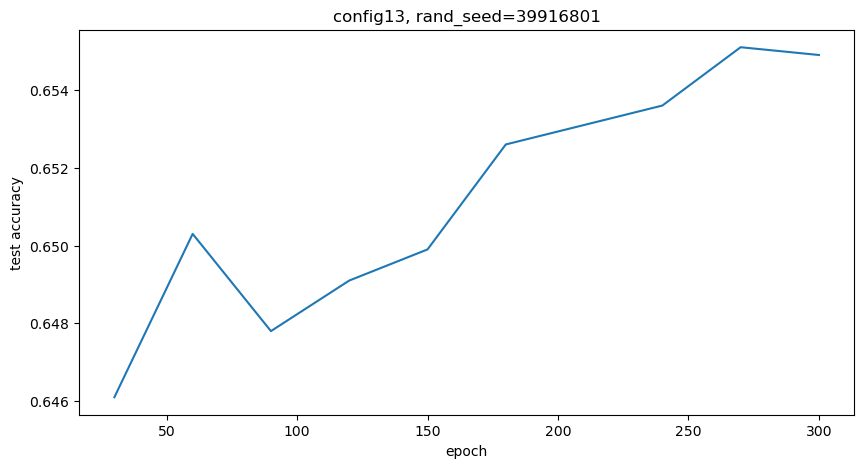

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.9647. Initial test accu: 0.6565
Epoch 30: Train Loss: 0.9298, Train Accu: 0.6607, test loss: 0.9619, test accu: 0.6602
Epoch 30 time: 10.36s
Epoch 60: Train Loss: 0.9277, Train Accu: 0.6613, test loss: 0.9698, test accu: 0.6507
Epoch 60 time: 10.95s
Epoch 90: Train Loss: 0.9249, Train Accu: 0.6600, test loss: 0.9593, test accu: 0.6604
Epoch 90 time: 10.72s
Epoch 120: Train Loss: 0.9225, Train Accu: 0.6637, test loss: 0.9593, test accu: 0.6588
Epoch 120 time: 10.51s
Epoch 150: Train Loss: 0.9169, Train Accu: 0.6647, test loss: 0.9585, test accu: 0.6594
Epoch 150 time: 10.82s
Epoch 180: Train Loss: 0.9132, Train Accu: 0.6656, test loss: 0.9497, test accu: 0.6586
Epoch 180 time: 11.00s
Epoch 210: Train Loss: 0.9107, Train Accu: 0.6676, test loss: 0.9502, test accu: 0.6606
Epoch 210 time: 10.85s
Epoch 240: Train Loss: 0.9094, Train Accu: 0.6680, test loss: 0.9478, test accu: 0.6625
Epoch 240 time: 10.72s
Epoch 270: Tra

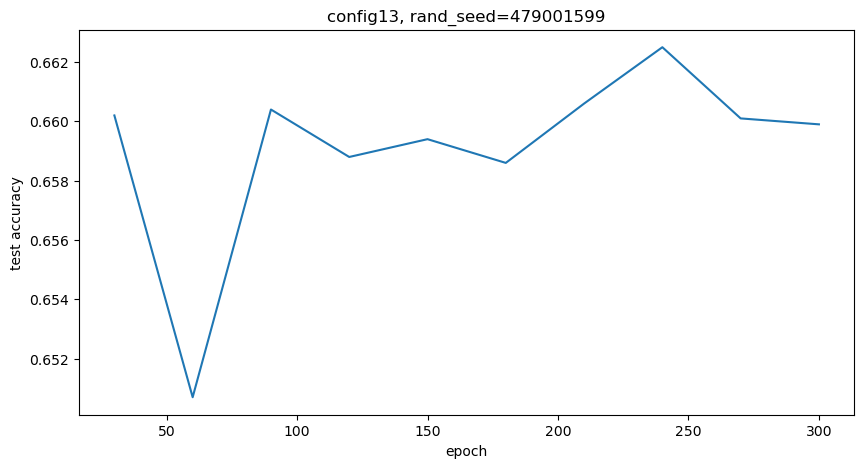

config14
StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6934. Initial test accu: 0.7682
Epoch 30: Train Loss: 0.6310, Train Accu: 0.7860, test loss: 0.6901, test accu: 0.7701
Epoch 30 time: 10.27s
Epoch 60: Train Loss: 0.6240, Train Accu: 0.7896, test loss: 0.6861, test accu: 0.7729
Epoch 60 time: 9.89s
Epoch 90: Train Loss: 0.6194, Train Accu: 0.7906, test loss: 0.6912, test accu: 0.7679
Epoch 90 time: 10.47s
Epoch 120: Train Loss: 0.6170, Train Accu: 0.7928, test loss: 0.6808, test accu: 0.7714
Epoch 120 time: 10.37s
Epoch 150: Train Loss: 0.6131, Train Accu: 0.7929, test loss: 0.6794, test accu: 0.7703
Epoch 150 time: 10.03s
Epoch 180: Train Loss: 0.6087, Train Accu: 0.7939, test loss: 0.6779, test accu: 0.7742
Epoch 180 time: 10.44s
Epoch 210: Train Loss: 0.6069, Train Accu: 0.7954, test loss: 0.6777, test accu: 0.7710
Epoch 210 time: 10.46s
Epoch 240: Train Loss: 0.6034, Train Accu: 0.7958, test loss: 0.6772, test accu: 0.7727
Epoch 240 time: 10.07s
Epoch 

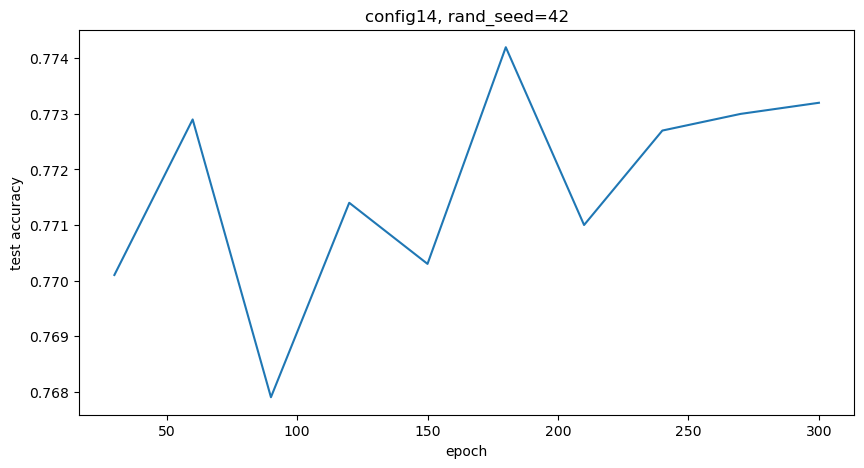

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6480. Initial test accu: 0.7786
Epoch 30: Train Loss: 0.6000, Train Accu: 0.7942, test loss: 0.6541, test accu: 0.7723
Epoch 30 time: 10.03s
Epoch 60: Train Loss: 0.5955, Train Accu: 0.7949, test loss: 0.6487, test accu: 0.7776
Epoch 60 time: 10.50s
Epoch 90: Train Loss: 0.5927, Train Accu: 0.7969, test loss: 0.6511, test accu: 0.7759
Epoch 90 time: 10.12s
Epoch 120: Train Loss: 0.5906, Train Accu: 0.7969, test loss: 0.6533, test accu: 0.7723
Epoch 120 time: 10.91s
Epoch 150: Train Loss: 0.5854, Train Accu: 0.7978, test loss: 0.6410, test accu: 0.7785
Epoch 150 time: 10.79s
Epoch 180: Train Loss: 0.5837, Train Accu: 0.7983, test loss: 0.6412, test accu: 0.7802
Epoch 180 time: 10.65s
Epoch 210: Train Loss: 0.5795, Train Accu: 0.7993, test loss: 0.6398, test accu: 0.7805
Epoch 210 time: 10.81s
Epoch 240: Train Loss: 0.5786, Train Accu: 0.7996, test loss: 0.6409, test accu: 0.7809
Epoch 240 time: 10.24s
Epoch 270: Tra

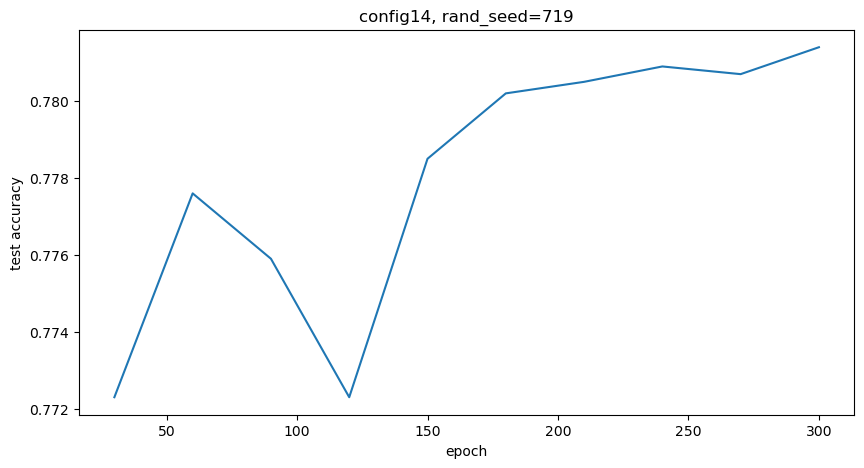

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6813. Initial test accu: 0.7664
Epoch 30: Train Loss: 0.6298, Train Accu: 0.7779, test loss: 0.6840, test accu: 0.7633
Epoch 30 time: 9.63s
Epoch 60: Train Loss: 0.6243, Train Accu: 0.7806, test loss: 0.6759, test accu: 0.7729
Epoch 60 time: 10.96s
Epoch 90: Train Loss: 0.6172, Train Accu: 0.7830, test loss: 0.6697, test accu: 0.7726
Epoch 90 time: 10.55s
Epoch 120: Train Loss: 0.6124, Train Accu: 0.7837, test loss: 0.6668, test accu: 0.7731
Epoch 120 time: 10.78s
Epoch 150: Train Loss: 0.6096, Train Accu: 0.7869, test loss: 0.6695, test accu: 0.7676
Epoch 150 time: 10.82s
Epoch 180: Train Loss: 0.6058, Train Accu: 0.7872, test loss: 0.6634, test accu: 0.7705
Epoch 180 time: 11.12s
Epoch 210: Train Loss: 0.6045, Train Accu: 0.7875, test loss: 0.6617, test accu: 0.7728
Epoch 210 time: 11.44s
Epoch 240: Train Loss: 0.6010, Train Accu: 0.7887, test loss: 0.6612, test accu: 0.7710
Epoch 240 time: 10.82s
Epoch 270: Trai

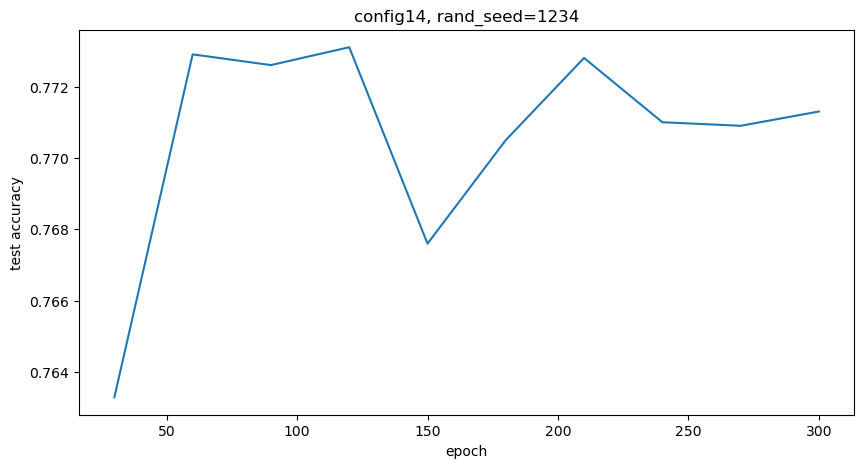

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6719. Initial test accu: 0.7760
Epoch 30: Train Loss: 0.6236, Train Accu: 0.7872, test loss: 0.6695, test accu: 0.7817
Epoch 30 time: 11.61s
Epoch 60: Train Loss: 0.6191, Train Accu: 0.7894, test loss: 0.6719, test accu: 0.7736
Epoch 60 time: 11.26s
Epoch 90: Train Loss: 0.6168, Train Accu: 0.7896, test loss: 0.6615, test accu: 0.7807
Epoch 90 time: 9.29s
Epoch 120: Train Loss: 0.6145, Train Accu: 0.7899, test loss: 0.6650, test accu: 0.7803
Epoch 120 time: 10.29s
Epoch 150: Train Loss: 0.6100, Train Accu: 0.7919, test loss: 0.6601, test accu: 0.7810
Epoch 150 time: 10.41s
Epoch 180: Train Loss: 0.6056, Train Accu: 0.7926, test loss: 0.6581, test accu: 0.7801
Epoch 180 time: 11.07s
Epoch 210: Train Loss: 0.6047, Train Accu: 0.7942, test loss: 0.6558, test accu: 0.7822
Epoch 210 time: 10.90s
Epoch 240: Train Loss: 0.6013, Train Accu: 0.7949, test loss: 0.6557, test accu: 0.7821
Epoch 240 time: 10.75s
Epoch 270: Trai

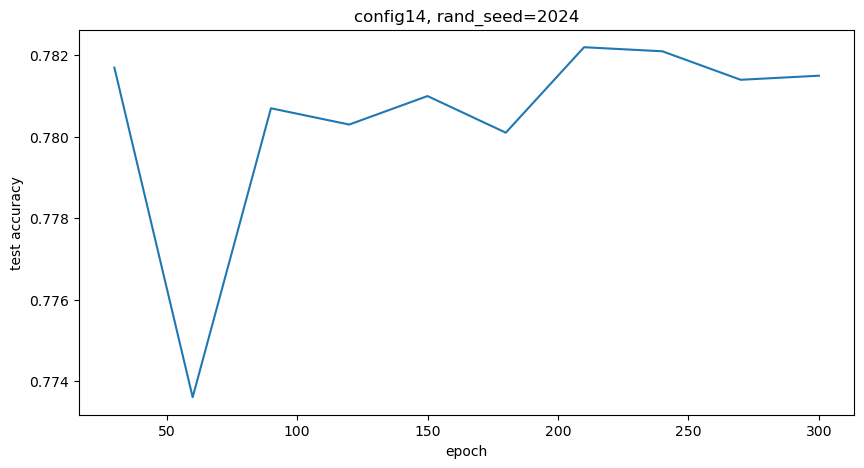

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6921. Initial test accu: 0.7692
Epoch 30: Train Loss: 0.6440, Train Accu: 0.7810, test loss: 0.6916, test accu: 0.7684
Epoch 30 time: 9.95s
Epoch 60: Train Loss: 0.6379, Train Accu: 0.7843, test loss: 0.6842, test accu: 0.7747
Epoch 60 time: 10.84s
Epoch 90: Train Loss: 0.6349, Train Accu: 0.7861, test loss: 0.6813, test accu: 0.7751
Epoch 90 time: 11.09s
Epoch 120: Train Loss: 0.6289, Train Accu: 0.7870, test loss: 0.6818, test accu: 0.7748
Epoch 120 time: 11.05s
Epoch 150: Train Loss: 0.6240, Train Accu: 0.7889, test loss: 0.6785, test accu: 0.7724
Epoch 150 time: 10.80s
Epoch 180: Train Loss: 0.6228, Train Accu: 0.7899, test loss: 0.6756, test accu: 0.7759
Epoch 180 time: 11.02s
Epoch 210: Train Loss: 0.6178, Train Accu: 0.7923, test loss: 0.6779, test accu: 0.7732
Epoch 210 time: 9.71s
Epoch 240: Train Loss: 0.6162, Train Accu: 0.7930, test loss: 0.6725, test accu: 0.7769
Epoch 240 time: 10.31s
Epoch 270: Train

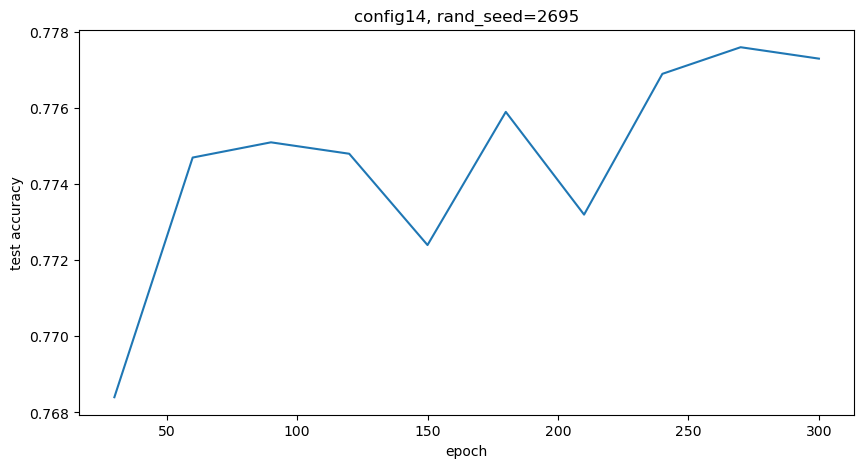

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6891. Initial test accu: 0.7669
Epoch 30: Train Loss: 0.6362, Train Accu: 0.7815, test loss: 0.6853, test accu: 0.7656
Epoch 30 time: 10.49s
Epoch 60: Train Loss: 0.6265, Train Accu: 0.7847, test loss: 0.6817, test accu: 0.7646
Epoch 60 time: 10.58s
Epoch 90: Train Loss: 0.6233, Train Accu: 0.7862, test loss: 0.6729, test accu: 0.7771
Epoch 90 time: 10.63s
Epoch 120: Train Loss: 0.6191, Train Accu: 0.7870, test loss: 0.6697, test accu: 0.7743
Epoch 120 time: 10.69s
Epoch 150: Train Loss: 0.6157, Train Accu: 0.7886, test loss: 0.6671, test accu: 0.7709
Epoch 150 time: 10.25s
Epoch 180: Train Loss: 0.6121, Train Accu: 0.7887, test loss: 0.6629, test accu: 0.7748
Epoch 180 time: 9.44s
Epoch 210: Train Loss: 0.6081, Train Accu: 0.7901, test loss: 0.6621, test accu: 0.7748
Epoch 210 time: 9.77s
Epoch 240: Train Loss: 0.6055, Train Accu: 0.7912, test loss: 0.6591, test accu: 0.7768
Epoch 240 time: 10.43s
Epoch 270: Train

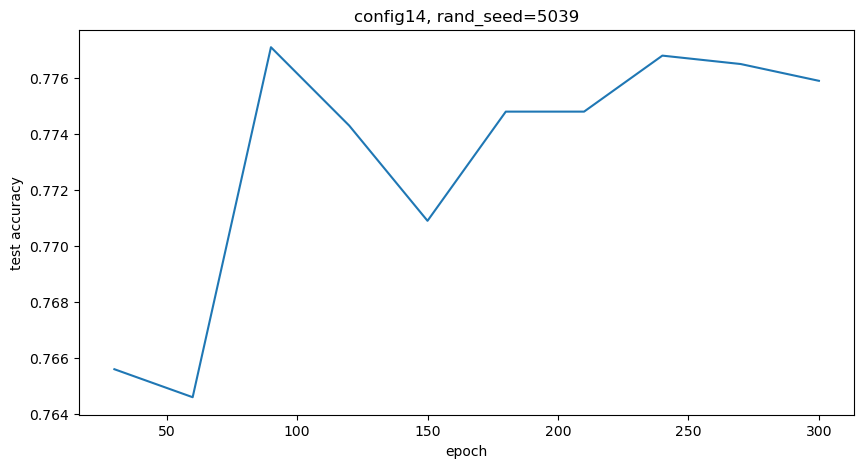

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6574. Initial test accu: 0.7787
Epoch 30: Train Loss: 0.6023, Train Accu: 0.7922, test loss: 0.6579, test accu: 0.7750
Epoch 30 time: 9.71s
Epoch 60: Train Loss: 0.5973, Train Accu: 0.7945, test loss: 0.6525, test accu: 0.7798
Epoch 60 time: 10.59s
Epoch 90: Train Loss: 0.5925, Train Accu: 0.7963, test loss: 0.6462, test accu: 0.7813
Epoch 90 time: 9.65s
Epoch 120: Train Loss: 0.5893, Train Accu: 0.7980, test loss: 0.6478, test accu: 0.7795
Epoch 120 time: 9.64s
Epoch 150: Train Loss: 0.5861, Train Accu: 0.7993, test loss: 0.6448, test accu: 0.7811
Epoch 150 time: 9.55s
Epoch 180: Train Loss: 0.5822, Train Accu: 0.8011, test loss: 0.6384, test accu: 0.7863
Epoch 180 time: 9.46s
Epoch 210: Train Loss: 0.5786, Train Accu: 0.8018, test loss: 0.6377, test accu: 0.7848
Epoch 210 time: 9.48s
Epoch 240: Train Loss: 0.5761, Train Accu: 0.8026, test loss: 0.6370, test accu: 0.7869
Epoch 240 time: 10.23s
Epoch 270: Train Los

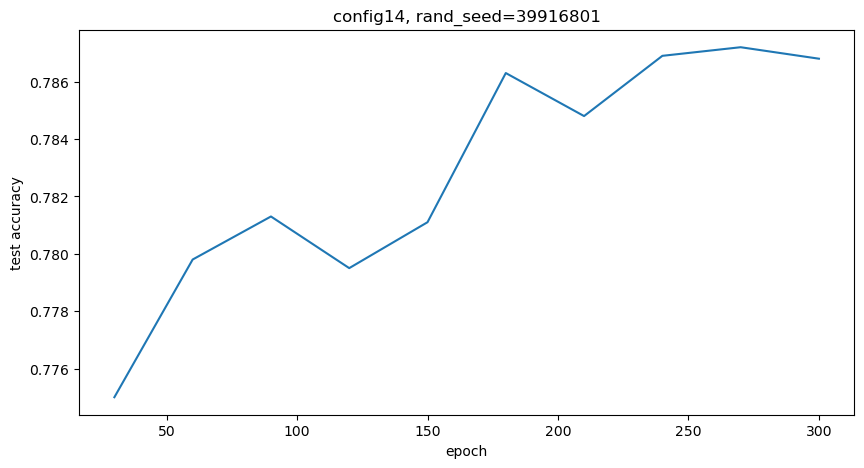

StructuralBlocDiagModel weights successfully set. Initial test loss = 0.6862. Initial test accu: 0.7702
Epoch 30: Train Loss: 0.6357, Train Accu: 0.7812, test loss: 0.6899, test accu: 0.7699
Epoch 30 time: 10.12s
Epoch 60: Train Loss: 0.6280, Train Accu: 0.7860, test loss: 0.6726, test accu: 0.7727
Epoch 60 time: 10.12s
Epoch 90: Train Loss: 0.6224, Train Accu: 0.7878, test loss: 0.6751, test accu: 0.7779
Epoch 90 time: 9.48s
Epoch 120: Train Loss: 0.6183, Train Accu: 0.7888, test loss: 0.6681, test accu: 0.7756
Epoch 120 time: 10.84s
Epoch 150: Train Loss: 0.6155, Train Accu: 0.7900, test loss: 0.6646, test accu: 0.7745
Epoch 150 time: 9.69s
Epoch 180: Train Loss: 0.6107, Train Accu: 0.7910, test loss: 0.6634, test accu: 0.7787
Epoch 180 time: 10.01s
Epoch 210: Train Loss: 0.6087, Train Accu: 0.7925, test loss: 0.6617, test accu: 0.7785
Epoch 210 time: 9.82s
Epoch 240: Train Loss: 0.6049, Train Accu: 0.7932, test loss: 0.6581, test accu: 0.7797
Epoch 240 time: 9.66s
Epoch 270: Train L

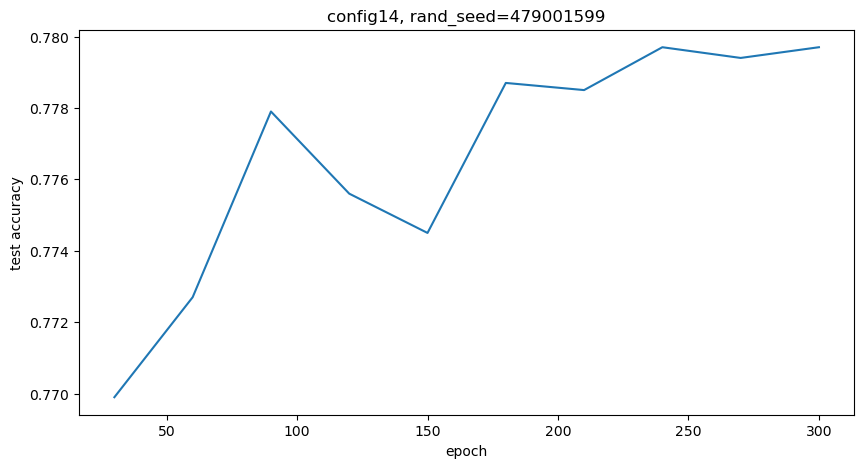

In [14]:
EST_time_zone = pytz.timezone('US/Eastern')


config_name_to_fine_tune = ['config11', 'config12', 'config13', 'config14']

for config_idx in range(len(config_name_to_fine_tune)):
    print(config_name_to_fine_tune[config_idx])
    df_to_fine_tune = df_fashion_MNIST_test[df_fashion_MNIST_test['config_name'] == config_name_to_fine_tune[config_idx]]
    
    for index, row in df_to_fine_tune.iterrows():

        dict_fine_tune_config = row.to_dict()
        
        ### rearrange the dict
        dict_fine_tune_config['model_name'] = 'structural_bloc_diag_model'
        dict_fine_tune_config['layer_sizes'] = ast.literal_eval(dict_fine_tune_config['layer_sizes'])
        _ = dict_fine_tune_config.pop('learning_rate', 'No such key')
        _ = dict_fine_tune_config.pop('scheduler_step_size', 'No such key')
        _ = dict_fine_tune_config.pop('scheduler_gamma', 'No such key')
        _ = dict_fine_tune_config.pop('train_loader_batch_size', 'No such key')
        _ = dict_fine_tune_config.pop('stopping_epoch', 'No such key')
        _ = dict_fine_tune_config.pop('multiplier_off_diag_loss', 'No such key')
        _ = dict_fine_tune_config.pop('test_accuracy_before_dropping', 'No such key')
        _ = dict_fine_tune_config.pop('time_consumption(s)', 'No such key')
        
        dict_fine_tune_config['random_seed__before_fine_tune'] = dict_fine_tune_config.pop('random_seed')
        dict_fine_tune_config['time__before_fine_tune'] = dict_fine_tune_config.pop('time')
        dict_fine_tune_config['train_accuracy__before_fine_tune'] = dict_fine_tune_config.pop('train_accuracy')
        dict_fine_tune_config['test_accuracy_off_diag_dropped__before_fine_tune'] = dict_fine_tune_config.pop('test_accuracy_off_diag_dropped')
        
        ### update configs for fine tuning
        dict_fine_tune_config['starting_learning_rate'] = fine_tune_config['starting_learning_rate']
        dict_fine_tune_config['weight_decay'] = fine_tune_config['weight_decay']
        dict_fine_tune_config['scheduler'] = fine_tune_config['scheduler']
        dict_fine_tune_config['T_max'] = fine_tune_config['T_max']
        dict_fine_tune_config['eta_min'] = fine_tune_config['eta_min']
        dict_fine_tune_config['stopping_epoch'] = fine_tune_config['stopping_epoch']
        dict_fine_tune_config['train_loader_batch_size'] = fine_tune_config['train_loader_batch_size']
        
        
        dict_fine_tune_config['random_seed'] = dict_fine_tune_config['random_seed__before_fine_tune']
        
        
        
        ### model folder directory
        dir_bd_model_folder = (
            f"./bloc_diag_results/bloc_diag_dataset={dict_fine_tune_config['dataset']}"
            f"/models__dataset={dict_fine_tune_config['dataset']}_"
            f"bias={dict_fine_tune_config['if_bias']}_"
            f"nonlinearity={dict_fine_tune_config['nonlinear_activation']}"
        )
        dir_sbd_model_folder = (
            f"structural_bloc_diag_dataset={dict_fine_tune_config['dataset']}"
            f"/sbd_models__dataset={dict_fine_tune_config['dataset']}"
        )
        df_path = os.path.join(f"structural_bloc_diag_dataset={dict_fine_tune_config['dataset']}",
                               f"test_results__SBDmodels__dataset={dict_fine_tune_config['dataset']}"
                               f"_bias={dict_fine_tune_config['if_bias']}"
                               f"_nonlinearity={dict_fine_tune_config['nonlinear_activation']}.csv")
        if os.path.exists(df_path):
            df_results = pd.read_csv(df_path)
        else:
            df_results = pd.DataFrame()
        
        
        
        
        
        
        
        
        
        if dict_fine_tune_config['dataset'] == 'MNIST':
            train_data = train_MNIST
            test_data  = test_MNIST
        elif dict_fine_tune_config['dataset'] == 'fashion-MNIST':
            train_data = train_fashion_MNIST
            test_data  = test_fashion_MNIST
        elif dict_fine_tune_config['dataset'] == 'Kuzushiji-MNIST':
            train_data = train_Kuzushiji_MNIST
            test_data  = test_Kuzushiji_MNIST
        else:
            raise ValueError("Unknown dataset name")
        
        
        
        
        
        torch.manual_seed(dict_fine_tune_config['random_seed'])
        np.random.seed(dict_fine_tune_config['random_seed'])
        
        
        train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=dict_fine_tune_config['train_loader_batch_size'])
        test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=1000)
        
        
        # Initialize BlocDiagModel
        row_blocks, col_blocks = translate_nonzero_blocks(dict_fine_tune_config['nonzero_blocks'])
        
        pretrained_bd_model = BlocDiagModel(dict_fine_tune_config['layer_sizes'], row_blocks, col_blocks,
                                            dict_fine_tune_config['if_bias'], dict_fine_tune_config['nonlinear_activation'])
        pretrained_bd_model_path = (
            f"{dir_bd_model_folder}"
            f"/bloc_diag_model__data={dict_fine_tune_config['dataset']}"
            f"__{dict_fine_tune_config['time__before_fine_tune']}.pt"
        )
        pretrained_bd_model.load_state_dict(torch.load(pretrained_bd_model_path))
        ### get weights in pretrained_bd_model
        weights_list = [param.data for name, param in pretrained_bd_model.named_parameters() if 'weight' in name]
        
        sbd_model = StructuralBlocDiagModel(dict_fine_tune_config['layer_sizes'], row_blocks, col_blocks,
                                                dict_fine_tune_config['if_bias'], dict_fine_tune_config['nonlinear_activation'])
        sbd_model.set_all_layers_from_full_matrices(weights_list)
        sbd_model.to(device)
        criterion = nn.CrossEntropyLoss()
    
        test_loss, test_accuracy = test_sbd_model(sbd_model, test_loader, criterion, device)
        
        # Print and optionally log the metrics
        print(f"StructuralBlocDiagModel weights successfully set. Initial test loss = {test_loss:.4f}. Initial test accu: {test_accuracy:.4f}")
    
    
    
    
        optimizer = optim.AdamW(sbd_model.parameters(),
                                lr=dict_fine_tune_config['starting_learning_rate'],
                                weight_decay=dict_fine_tune_config['weight_decay'])
        if dict_fine_tune_config['scheduler'] == 'cosine annealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=dict_fine_tune_config['T_max'],
                                                             eta_min=dict_fine_tune_config['eta_min'])
        else:
            raise ValueError("scheduler is unspecified")
        
        
        
        t_start = time.time()
    
        test_accuracies = []
    
        for epoch in range(dict_fine_tune_config['stopping_epoch']):
            epoch_start_time = time.time()
            
            # Initialize metrics
            correct, total, train_loss, counter = 0, 0, 0, 0
        
            # Training loop
            for data in train_loader:
                sbd_model.train()  # Set model to training mode
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
        
                # Forward pass and loss calculation
                outputs = sbd_model(inputs)
                loss = criterion(outputs, labels)
        
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                # Update training metrics
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                train_loss += loss.item()
                counter += 1
    
            # Evaluate on the test set every 10 epochs
            if (epoch + 1) % 30 == 0:
                train_accuracy = correct / total
                avg_train_loss = train_loss / counter
                test_loss, test_accuracy = test_sbd_model(sbd_model, test_loader, criterion, device)
                test_accuracies.append(test_accuracy)
        
                # Print and optionally log the metrics
                print(f'Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Train Accu: {train_accuracy:.4f}, test loss: {test_loss:.4f}, test accu: {test_accuracy:.4f}')
                # Report epoch duration
                print("Epoch {} time: {:.2f}s".format(epoch + 1, time.time() - epoch_start_time))
            
        
            scheduler.step()
        
        
        # Evaluate on the test set
        train_accuracy = correct / total
        avg_train_loss = train_loss / counter
        test_loss, test_accuracy = test_sbd_model(sbd_model, test_loader, criterion, device)
        
        # Print and optionally log the metrics
        print(f'Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Train Accu: {train_accuracy:.4f}, test loss: {test_loss:.4f}, test accu: {test_accuracy:.4f}')
        # Report epoch duration
        t_end = time.time()
        
        
        
        current_time_est = datetime.datetime.now(EST_time_zone)
        time_str = current_time_est.strftime("%Y-%m-%d_%H-%M-%S")


        dict_fine_tune_config['time'] = time_str
        dict_fine_tune_config['train_accuracy'] = train_accuracy
        dict_fine_tune_config['test_accuracy'] = test_accuracy
        dict_fine_tune_config['time_consumption(s)'] = t_end - t_start


        plt.figure(figsize=(10, 5))
        plt.plot(list(range(30, dict_fine_tune_config['stopping_epoch']+1, 30)), test_accuracies, label='test accuracy')
        plt.xlabel('epoch')
        plt.ylabel('test accuracy')
        plt.title(f"{dict_fine_tune_config['config_name']}, rand_seed={dict_fine_tune_config['random_seed']}")
        plt.show()


        # save result to spreadsheet
        df_results = pd.concat([df_results, pd.DataFrame([dict_fine_tune_config])], ignore_index=True)
        df_results.to_csv(df_path, index=False)


        ### save the model
        torch.save(sbd_model.state_dict(), f"{dir_sbd_model_folder}/{dict_fine_tune_config['model_name']}__data={dict_fine_tune_config['dataset']}__{time_str}.pt")
        torch.save(optimizer.state_dict(), f"{dir_sbd_model_folder}/optimizer__{dict_fine_tune_config['model_name']}__data={dict_fine_tune_config['dataset']}__{time_str}.pt")
